# Using GNN to predict the ice crystal rotation and offset

In [ ]:
import h5py
import ase
import tqdm
import dgl
import numpy as np
import matplotlib.pyplot as plt
from dataset.crystal import Layer2CrystalDataset, RotateOnly
from model.gnn import GCN
from utils.const import ice_search_bound
from functools import partial
from dataset.sampler import collate_fn

import torch 
from torch.utils.data import DataLoader
from torch.nn import functional as F


from ase.visualize import view



In [ ]:
traindts = RotateOnly('../data/ice_16A_R_all_train.hdf5')
testdts = RotateOnly('../data/ice_16A_R_all_test.hdf5')
traindtl = DataLoader(traindts, batch_size=8, shuffle=True, collate_fn=collate_fn, num_workers=0)
testdtl = DataLoader(testdts, batch_size=8, shuffle=True, collate_fn=collate_fn, num_workers=0)

In [ ]:
import torch
from torch import nn
def periodic_output(x: torch.Tensor):
    # x = x.tanh()
    x_cos = x[:, 0::2].cos()
    x_sin = x[:, 1::2].sin()
    x = torch.atan2(x_sin, x_cos) # [-pi, pi]
    x = x / torch.pi # [-1, 1]
    return x
    

In [ ]:
net = GCN(9, 128, 2, 4)

opt = torch.optim.Adam(net.parameters(), lr = 1E-4)
# net.apply_transform(out = periodic_output)
net.apply_transform(out = torch.tanh)
total_epoch = 100

for e in range(total_epoch):
    dti = iter(traindtl)
    losses = []
    grads = []
    pbar = tqdm.tqdm(dti, desc=f"(train){e+1}/{total_epoch}")
    net.train()
    for i, (t_atom, t_grid, m_grid, g, y) in enumerate(pbar):
        ybar = net(g, t_atom)
        y = y[:,:1] * torch.pi
        y = torch.cat([y.cos(), y.sin()], dim = -1)
        loss = F.mse_loss(ybar, y)
        opt.zero_grad()
        loss.backward()
        grad = torch.nn.utils.clip_grad_norm_(net.parameters(), 10)
        losses.append(loss.item())
        grads.append(grad)
        opt.step()
        if i % 20 == 0:
            pbar.set_postfix(loss = np.mean(losses), grad = np.mean(grads))
            losses = []
            grads = []
        pbar.update(1)
    if e % 10 == 0:
        net.eval()
        dti = iter(testdtl)
        losses = []
        pbar = tqdm.tqdm(iter(testdtl), desc=f"(test){e+1}/{total_epoch}")
        for i, (t_atom, t_grid, m_grid, g, y) in enumerate(dti):
            ybar = net(g, t_atom)
            y = y[:,:1] * torch.pi
            y = torch.cat([y.cos(), y.sin()], dim = -1)
            loss = F.mse_loss(ybar, y)
            losses.append(loss.item())
        print(f"test loss: {np.mean(losses)}")
        


# Testing Code

In [ ]:

from ase.io import read
import torch
from torch import nn

atoms = read('../ARAI/outputs/2023-12-14/17-20-13/HDA4_-1_1_0_0.poscar.xyz')
atoms = atoms[atoms.symbols == 'O']
atoms = atoms.positions

atoms = torch.as_tensor(atoms, dtype = torch.float32)

class IceRuleCounter(nn.Module):
    def __init__(self, OO_cutoff: float = 3.4, layers = [0.0, 4.0, 8.0, 12.0, 16.0]):
        super().__init__()
        self.OO_cutoff = OO_cutoff
        self.layers = layers
        pass
    
    def forward(self, pos, cell= (25.0, 25.0, 16.0)):
        disc = torch.cdist(pos, pos).fill_diagonal_(self.OO_cutoff + 1)
        # disc = disc + torch.tril(torch.full_like(disc, self.OO_cutoff + 1), diagonal = -1)
        ajx = disc < self.OO_cutoff
        num_ajx = ajx.sum(dim = -1)
        
        xbound = (pos[:,0] > self.OO_cutoff) & (pos[:,0] < cell[0] - self.OO_cutoff)
        ybound = (pos[:,1] > self.OO_cutoff) & (pos[:,1] < cell[1] - self.OO_cutoff)
        zbound = (pos[:,2] > self.OO_cutoff) & (pos[:,2] < cell[2] - self.OO_cutoff)
        
        zlayers = []
        for low, high in zip(self.layers[:-1], self.layers[1:]):
            zlayers.append((pos[:,2] > low) & (pos[:,2] < high))
        
        dics = []
        for i, layer in enumerate(zlayers):
            
        
        # src, des = (disc < self.OO_cutoff).nonzero(as_tuple = True)

 
ICE = IceRuleCounter()

print(ICE(atoms))

In [ ]:
# torchrun --standalone --nnodes=1 --nproc-per-node=2 train.py
import os
from tqdm import tqdm
import h5py
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.nn import functional as F
from torch.utils.data import DataLoader
from dataset.dataset import PointGridDataset


In [ ]:
# inp = torch.randn(10, 10, 25, 25, 16)
# out, loss = net(inp)
epochs = 50
net = VQVAE3D(10, 64, 0.25)
opt = torch.optim.Adam(net.parameters(), lr = 1E-4)
train_data = PointGridDataset("../data/ice_16A_R_hup_train.hdf5", noise_position= 0.01)
test_data = PointGridDataset("../data/ice_16A_R_hup_test.hdf5", noise_position= 0.01)
train_loader = DataLoader(train_data, 4, True, num_workers=0, pin_memory=True)

In [ ]:
for e in range(epochs):
    dti = iter(train_loader)
    pbar = tqdm(dti, desc=f"epoch {e+1}/{epochs}")
    losses = []
    for i, (name, y) in enumerate(pbar):
        opt.zero_grad()
        ybar, vq_loss = net(y)
        loss = F.mse_loss(ybar, y) + vq_loss
        losses.append(loss.item())
        if i % 20 == 0:
            pbar.set_postfix(loss = np.mean(losses))
            losses = []
        loss.backward()
        opt.step()
        pbar.update(1)
    

In [ ]:
name, y = test_data[0]
recon = net.sample(y[None])[0]
plt.imshow(recon[0, :, :, 0].detach().numpy())

In [ ]:
from ase.io import read
from matplotlib import pyplot as plt
import os, sys
from numba import prange
from tqdm import tqdm
import numpy as np

pth = "../data/ice_16_rotate/hup/t265/"
files = os.listdir(pth)

pos_z = []
for i in prange(len(files)):
    f = files[i]
    atoms = read(pth + f)
    atoms = atoms[atoms.symbols == 'O']
    atoms = atoms.positions
    pos_z.append(atoms[:,2])

pos_z = np.concatenate(pos_z)


In [ ]:
import os, sys
import numpy as np
from ase import Atoms
from ase.io import read
from ase.visualize import view
from matplotlib import pyplot as plt

from tqdm import tqdm
from scipy.spatial.distance import cdist
from scipy.stats import wasserstein_distance
np.set_printoptions(precision=3, suppress=True)

pth = "../data/ice_16_rotate/hup/t260/"
files = os.listdir(pth)
files.sort()
f = files[0]
print(f)

atoms = read(pth + f)
# atoms = atoms[atoms.symbols == 'O']
atoms.set_cell([25, 25, 16])


def ice_rule_counter(atoms: Atoms) -> float:
    """
    Calculate the score of a structure based on ice rules:
    
    `S = \sum (\rho_i * |f(x) - f(Y)|_i), i \in [corner, face, edge, inner]`
    
    Args:
        atoms (Atoms): input structure

    Returns:
        score (float): the wasserstein distance
    """
    
    stats_bonds = [[0.039, 0.401, 0.393, 0.149, 0.019, 0.   , 0.   ],
                   [0.008, 0.136, 0.427, 0.341, 0.087, 0.002, 0.   ],
                   [0.   , 0.025, 0.123, 0.529, 0.315, 0.007, 0.   ],
                   [0.   , 0.   , 0.002, 0.045, 0.931, 0.021, 0.001]]
    
    # Center the atoms
    atoms = atoms[atoms.symbols == 'O']
    atoms.center()
    # Get the cell and positions
    cell = atoms.cell.diagonal()
    pos = atoms.positions
    if np.all(cell == 0):
        cell_max = np.max(pos, axis = 0)
        cell_min = np.min(pos, axis = 0)
    else:
        cell_max = cell
        cell_min = np.zeros(3)
    
    # split boarder atoms and inner atoms
    bond_min = 3.0
    bond_max = 3.2
    dist = cdist(pos, pos, 'euclidean') + np.eye(len(pos)) * 100
    
    # Split atoms
    inner_atoms_axis = np.logical_and(pos > cell_min + bond_min, pos < cell_max - bond_min)
    inner_atoms_axis = np.sum(inner_atoms_axis, axis = 1)
    
    # count the number of bonds
    bonds = []
    for i in range(4):
        fitted = inner_atoms_axis == i
        inner_dist = dist[fitted]
        # print((inner_dist < bond_max).sum(1))
        neighbors = np.sum(inner_dist < bond_max, axis = 1)
        num_bonds, _ = np.histogram(neighbors, bins = 7, range = (0, 7.0))
        bonds.append(num_bonds)
    
    score = []
    for i,j in zip(bonds, stats_bonds):
        rho = np.sum(i)
        if rho == 0:
            score.append(0.0)
        else:
            score.append(rho / len(pos) * wasserstein_distance(i / rho, j))
    score = np.sum(score)
    return score
        
score = ice_rule_counter(atoms)

print(score)
# view(atoms)

In [ ]:

inner_atoms_count_all = []
for f in tqdm(files):
    atoms = read(pth + f)
    atoms, counts = ice_rule_counter(atoms)
    inner_atoms_count_all.append(counts)

inner_atoms_count_all = list(zip(*inner_atoms_count_all))
inner_atoms_count_all = [np.stack(i, axis = 0) for i in inner_atoms_count_all]
total_distribution = [np.sum(i, axis = 0) for i in inner_atoms_count_all]
total_distribution = [i / np.sum(i) for i in total_distribution]

print(total_distribution)

# corner: [0.039, 0.401, 0.393, 0.149, 0.019, 0.   , 0.   ]
# edge  : [0.008, 0.136, 0.427, 0.341, 0.087, 0.002, 0.   ]
# face  : [0.   , 0.025, 0.123, 0.529, 0.315, 0.007, 0.   ]
# inner : [0.   , 0.   , 0.002, 0.045, 0.931, 0.021, 0.001]

In [ ]:
data_wasserstein_distance = []
for f in tqdm(files):
    atoms = read(pth + f)
    score = ice_rule_counter(atoms)
    data_wasserstein_distance.append(score)

plt.hist(data_wasserstein_distance, bins = 50, density=True)
plt.show()

In [ ]:
pth = "./outputs/2024-01-17/17-35-47/"
files = os.listdir(pth)
files = list(filter(lambda x: x.endswith(".xyz"), files))

exp_wasserstein_distance = {}
for f in tqdm(files):
    atoms = read(pth + f)
    score = ice_rule_counter(atoms)
    exp_wasserstein_distance[f]= score
    
plt.hist(exp_wasserstein_distance.values(), bins = 50, density=True, label="exp")
plt.hist(data_wasserstein_distance, bins = 50, density=True, label="data")
plt.legend()
plt.show()

In [ ]:
exp_wasserstein_distance_list = list(exp_wasserstein_distance.items())
exp_wasserstein_distance_list.sort(key = lambda x: x[1])
print(exp_wasserstein_distance_list[-5:])

In [ ]:
import numpy as np
from ase import Atoms
from ase.visualize import view
a = Atoms(['O','H','H'] * 10, np.random.uniform(0, 10, (30, 3)), tags = np.arange(30))
view(a)

In [ ]:
import torch
from torch import nn

model = nn.ConvTranspose3d(1, 1, (3,4,4))

a = torch.randn(1, 1, 1, 1, 1)

b = model(a)

print(b.shape)
# print(b)

model = nn.ConvTranspose3d(1, 1, 3, stride = (1,2,2), padding = 1)

a = torch.randn(1, 1, 3, 4, 4)

b = model(a)

print(b.shape)

model = nn.ConvTranspose3d(1, 1, (4,3,3), stride = 2, padding = 1)

a = torch.randn(1, 1, 3, 7, 7)

b = model(a)

print(b.shape)

model = nn.ConvTranspose3d(1, 1, (4,3,3), stride = 2, padding = 1)

a = torch.randn(1, 1, 6, 13, 13)

b = model(a)

print(b.shape)
# print(b)

In [ ]:
import torch
from model.vaes.v4 import ConditioalVAE

model = ConditioalVAE(10, 32, 10, 8, 64, 0.0)

c = torch.zeros(1, 25, 25, 4, 10)
a = torch.randn(1, 25, 25, 12, 10)
x, mu, sigma = model(a)
loss, dic = model.compute_loss(x, a, mu, sigma)
print(f"x: {x.shape}, mu: {mu.shape}, sigma: {sigma.shape}")
print(loss, dic)

In [ ]:
import torch
from torchvision.utils import make_grid, save_image
import os, sys
import numpy as np
from ase import Atoms
from ase.io import read
from ase.visualize import view
from matplotlib import pyplot as plt
from utils.library import *

def water_molecule_to_grid(atoms: Atoms, grid_size: tuple[int]):
    atoms.center()
    cell_size = atoms.cell.diagonal()
    atoms = group_as_water(torch.as_tensor(atoms.positions[atoms.symbols == 'O'], dtype=torch.float), 
                            torch.as_tensor(atoms.positions[atoms.symbols == 'H'], dtype=torch.float))
    
    atoms = encodewater(atoms)
    
    atoms[:, :3] /= cell_size
    
    atoms = vec2box(atoms[:, :3], atoms[:, 3:], box_size = grid_size)
    return atoms
        
atoms = read("../data/ice_16_rotate/hup/t160/ice_basal_T160_1000000_0_0_0_102.xyz")
grid_size = [25, 25, 16]
atoms.set_cell([25, 25, 16])

grids = water_molecule_to_grid(atoms, grid_size=grid_size)[...,(0,)] # (25, 25, 16, 10)
fft_grids = torch.fft.fftn(grids, dim = (0, 1, 2), norm = "ortho")
fft_grids[18:] = 0
fft_grids[:, 18:] = 0
fft_grids[:,:,12:] = 0  

fft_grids = torch.fft.fftshift(fft_grids, dim = (0, 1, 2))
fft_grid_real, fft_grid_imag = fft_grids.real, fft_grids.imag
fft_grid_amp, fft_grid_phase = torch.abs(fft_grids), torch.angle(fft_grids)
print(fft_grid_amp.shape)
iff_grids_real, iff_grids_imag = torch.cos(fft_grid_phase) * fft_grid_amp, torch.sin(fft_grid_phase) * fft_grid_amp
iff_grids = torch.complex(iff_grids_real, iff_grids_imag)
iff_grids = torch.fft.ifftshift(iff_grids, dim = (0, 1, 2))
iff_grids = torch.fft.ifftn(iff_grids, dim = (0, 1, 2), norm="ortho")
print(iff_grids.shape)

img = make_grid(grids.permute(2,3,0,1), nrow=8, pad_value=0.5).permute(1,2,0).detach().numpy()
fft_img = make_grid(fft_grid_amp.permute(2,3,0,1), nrow=8, pad_value=0.5).permute(1,2,0).detach().numpy()
ifft_img = make_grid(iff_grids.real.permute(2,3,0,1), nrow=8, pad_value=0.5).permute(1,2,0).detach().numpy()

fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(311)
ax1.imshow(img)
ax2 = fig.add_subplot(312)
ax2.imshow(fft_img)
ax3 = fig.add_subplot(313)
ax3.imshow(ifft_img)


In [ ]:
import torch
from torch import fft
import numpy as np

def delta_function_cft(amplitudes, positions, frequencies):
    """
    amplitudes: Tensor of amplitudes (A_i)
    positions: Tensor of positions (t_i)
    frequencies: Tensor of frequencies (omega)
    """
    # 擴展維度以進行廣播
    positions = positions.unsqueeze(-1)
    frequencies = frequencies.unsqueeze(0)

    # 計算每個δ函數在頻率域的貢獻
    contributions = amplitudes[:, None] * torch.exp(-1j * positions * frequencies)
    
    # 將所有貢獻相加
    spectrum = contributions.sum(dim=0)

    return spectrum

def idft(frequency_data, frequencies, time_points):
    """
    frequency_data: Tensor of frequency domain data (F(omega))
    frequencies: Tensor of frequencies (omega)
    time_points: Tensor of time points (t) at which to evaluate the ICFT
    """
    # 拓展维度以进行广播
    frequencies = frequencies.unsqueeze(-1)
    time_points = time_points.unsqueeze(0)

    # 计算idft
    contributions = frequency_data[:, None] * torch.exp(1j * frequencies * time_points)
    
    # 由于积分的离散化，我们需要根据频率间隔进行加权求和
    frequency_interval = frequencies[1] - frequencies[0]

    time_domain_data = contributions.sum(dim=0) * frequency_interval * 2

    return time_domain_data

def gaussian_distribution(x, mu, sigma):
    dim = x.shape[-1]
    const = 1 / (sigma * np.sqrt(2 * np.pi)) ** dim
    power = -((x - mu) ** 2 / (2 * sigma ** 2)).sum(dim=-1, keepdim=True)
    return const * torch.exp(power)

def gaussian_cft(positions, amplitudes, frequencies):
    positions = positions.unsqueeze(0)
    frequencies = frequencies.unsqueeze(-1)
    
    gd = gaussian_distribution(frequencies, 0, 1 / sigma)
    phase = torch.exp(-1j * frequencies * positions)
    spectrum = gd * phase * amplitudes.unsqueeze(0)
    
    spectrum = spectrum.sum(dim = 1)
    return spectrum

# time_domain_data 现在包含在给定时间点上的时域数据
sigma = 0.3
space_length = 27
# 示例數據
position = torch.arange(1.0, 24.0, 5)
position = position + torch.rand_like(position) * 2
# frequencies = torch.linspace(0, 1 / 0.3 * 2, 41)    # 頻率範圍
freq = torch.arange(0, 2 / sigma, 2 * torch.pi / space_length)
frequencies_smooth = torch.linspace(0, 2 / sigma, 1001)    # 頻率範圍
# 計算CFT
spectrum = gaussian_cft(position, torch.ones_like(position), freq)
spectrum[0] = 0
spectrum_amp, spectrum_phase = torch.abs(spectrum), torch.angle(spectrum)

noisy_spectrum = spectrum + torch.randn_like(spectrum) * 0.1
noisy_spectrum_amp, noisy_spectrum_phase = torch.abs(noisy_spectrum), torch.angle(noisy_spectrum)

spectrum_smooth = gaussian_cft(position, torch.ones_like(position), frequencies_smooth)
spectrum_smooth_amp, spectrum_smooth_phase = torch.abs(spectrum_smooth), torch.angle(spectrum_smooth)
# spectrum = delta_function_cft(amplitudes, positions, frequencies)
sample_points = torch.linspace(0, space_length, 1000)  # 采样点
reverse_amp = idft(spectrum, freq, sample_points).real
reverse_amp_smooth = idft(spectrum_smooth, frequencies_smooth, sample_points).real
noisy_reverse_amp = idft(noisy_spectrum, freq, sample_points).real


# fft 
fft_reverse_amp = torch.fft.ifft(spectrum, n=len(sample_points), norm="forward").real / 2
fft_reverse_amp -= 0.5 * (torch.max(fft_reverse_amp) + torch.min(fft_reverse_amp) -1)

# print(spectrum)

# print(time_domain_data.real, positions)

import matplotlib.pyplot as plt

# print(amplitudes / time_domain_data.real)

fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(221)
ax.set_title("Point set after Gaussian CFT transform and inverse transform")
# ax.plot(sample_points,reverse_amp, label = "ICFT")
ax.plot(sample_points,reverse_amp_smooth, label = "ICFT smooth")
ax.scatter(position, torch.ones_like(position), c='r', label = "original")
# ax.plot(sample_points, noisy_reverse_amp, label = "noisy ICFT")
ax.plot(sample_points, fft_reverse_amp, label = "ifft")
ax.legend(loc=1)

ax = fig.add_subplot(222)
ax.set_title("Spectrum Domain for Gaussian CFT, in Amplitude and Phase domain")
ax.plot(frequencies_smooth, spectrum_smooth_amp, label = "amp")
ax.plot(frequencies_smooth, spectrum_smooth_phase, label = "phase")
ax.scatter(freq, spectrum_amp, label = f"m={len(freq)}")
ax.scatter(freq, spectrum_phase)
ax.scatter(freq, noisy_spectrum_amp, label = f"m={len(freq)}")
ax.legend(loc=1)

ax = fig.add_subplot(223)
ax.set_title("Spectrum Domain for Gaussian CFT, in Real and Imagine domain")
ax.scatter(spectrum_smooth.real, spectrum_smooth.imag, label = "label")
ax.scatter(spectrum.real, spectrum.imag, label = "grid")
ax.scatter(noisy_spectrum.real, noisy_spectrum.imag, label = "noisy")
ax.legend(loc=1)

## 2D

In [ ]:
from scipy.optimize import minimize

def gaussian_cftn(position: torch.Tensor, freqs: list, amplitude: torch.Tensor | None = None):
    assert position.shape[-1] == len(freqs), "Dimension of positions and frequencies should be the same"
    if amplitude is None:
        amplitude = position.new_ones(len(position))
    grid_size = [len(i) for i in freqs]
    freqs = torch.stack(torch.meshgrid(*freqs), dim = -1).reshape(-1, len(freqs))
    transformed_gaussian = gaussian_distribution(freqs, 0, 1 / sigma)
    phase = torch.exp(-1j * (freqs @ position.T))
    spectrum = transformed_gaussian * phase * amplitude[None]
    spectrum = spectrum.sum(dim = 1).reshape(grid_size)
    return spectrum

def idftn(spectrum: torch.Tensor, freqs: list, position: torch.Tensor):
    assert position.shape[-1] == len(freqs) == spectrum.ndim, "Dimension of points and frequencies should be the same"
    const = 2 ** len(freqs) * np.prod([i[1] - i[0] for i in freqs])
    freqs = torch.stack(torch.meshgrid(*freqs), dim = -1).reshape(-1, len(freqs))
    contributions = spectrum.reshape(-1, 1) * torch.exp(1j * (freqs @ position.T))
    position = contributions.sum(dim=0) * const
    return position

total_points = 100
random_positions = torch.rand(total_points, 2) * 25
disc = torch.cdist(random_positions, random_positions) + torch.eye(total_points) * 100
mask = torch.ones(len(random_positions))
for i in range(total_points):
    if mask[i] == 0:
        continue
    buf = torch.logical_and(disc[i] < 2.8, mask)
    mask[buf] = 0
random_positions = random_positions[mask == 1]

freq = torch.arange(0, 2 / sigma, sigma / 1.5)
num_freq = len(freq)

freq_domain = gaussian_cftn(random_positions, [freq, freq])

idft_test_points = torch.linspace(0, 25, 100)
idft_test_points = torch.stack(torch.meshgrid(idft_test_points, idft_test_points, indexing='ij'), dim = -1).reshape(-1, 2)

idft_test_points_value = idftn(freq_domain, [freq, freq], idft_test_points).abs()
# idft_test_points_value = torch.where(idft_test_points_value > 0.1, idft_test_points_value, 0)
idft_freq_domain = idftn(freq_domain, [freq, freq], random_positions).real

freq_domain_image = freq_domain.reshape(num_freq, num_freq)
freq_domain_amp, freq_domain_phase = torch.abs(freq_domain_image), torch.angle(freq_domain_image)

fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(221)
axs = ax.imshow(freq_domain_amp.detach().numpy())
fig.colorbar(axs)
ax = fig.add_subplot(222)
ax.imshow(freq_domain_phase.detach().numpy())
ax = fig.add_subplot(223)
ax.scatter(freq_domain_image.real, freq_domain_image.imag)
ax = fig.add_subplot(224)

axs = ax.contourf(torch.linspace(0, 25, 100), torch.linspace(0, 25, 100), idft_test_points_value.detach().numpy().reshape(100, 100).T)
ax.scatter(random_positions[:,0], random_positions[:,1], c='r')
ax.set_aspect('equal', 'box')
ax.set_xlim(0, 25)
ax.set_ylim(0, 25)
ax.set_xticks(np.arange(0, 26, 1), minor=True)
ax.set_yticks(np.arange(0, 26, 1), minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
fig.colorbar(axs)
ax.scatter(random_positions[:,0], random_positions[:,1], c='r')

# def find_local_minima(start_points, spectrum, start_positions,):
#     local_minima = []
#     for start in start_points:
#         res = minimize(lambda x: , start, method='L-BFGS-B')
#         if res.success:
#             local_minima.append(res.x)
#     return local_minima
print(freq_domain_amp[0,0])

In [ ]:
import numpy as np
import torch
def gaussian_cftn(position: torch.Tensor, freqs: list, amplitude: torch.Tensor | None = None, sigma: float  = 1):
    def gaussian_distribution_1d(xs, mu, sigma):
        return 1 / (sigma * np.sqrt(2 * np.pi)) * (- (xs - mu) ** 2 / (2 * sigma ** 2)).exp()
    
    assert position.shape[-1] == len(freqs), "Dimension of positions and frequencies should be the same"
    amplitude = amplitude or position.new_ones(len(position))
    grid_size = [len(i) for i in freqs]
    
    gaussian_freqs = [gaussian_distribution_1d(freqs[i], 0, 1 / sigma) for i in range(len(freqs))]
    gaussian_freqs = torch.outer(*gaussian_freqs)
    
    freqs = torch.stack(torch.meshgrid(*freqs), dim = -1)
    phase = (torch.exp(-1j * (freqs @ position.T)) * amplitude[None]).sum(dim = -1)
    spectrum = gaussian_freqs * phase
    # spectrum = spectrum / spectrum[0,0]
    spectrum[0,0] = 0
    return spectrum

def sparse_point_generator(num_points: int, cutoff: float, ndim: int = 2, grid_size: int = 25):
    points = torch.rand(num_points, ndim) * grid_size
    disc = torch.cdist(points, points) + torch.eye(num_points) * 100
    mask = torch.full((len(points),), True)
    for i in range(num_points):
        if mask[i] == 0:
            continue
        buf = torch.logical_and(disc[i] < cutoff, mask)
        mask[buf] = False
    return points[mask]

sigma = 0.3
resolution = 10000

space_length = 23
points = sparse_point_generator(100, 2.8, 2, space_length-1)

freqs = [torch.arange(0, 2 / sigma, 2 * torch.pi / space_length), torch.arange(0, 2 / sigma, 2 * torch.pi / space_length)]
freqs_grid = torch.stack(torch.meshgrid(*freqs), dim = -1)
spectrum = gaussian_cftn(points, freqs, sigma = sigma)
centers = torch.fft.ifft2(spectrum, norm="backward", s=(resolution, resolution)).abs()
print(spectrum[5:10,5:10])
related_points = torch.stack(torch.meshgrid(torch.linspace(0, space_length, resolution), torch.linspace(0, space_length, resolution), indexing='ij'), dim = -1)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
img = ax.imshow(spectrum.abs())
fig.colorbar(img)

ax = fig.add_subplot(122)
cont = ax.contourf(related_points[:,:,0], related_points[:,:,1], centers)
fig.colorbar(cont)
ax.scatter(points[:,0], points[:,1], c='r')
ax.set_aspect('equal', 'box')
ax.set_xlim(0, space_length)
ax.set_ylim(0, space_length)



In [ ]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

class Gaussian_cftn(nn.Module):
    def __init__(self, *freq, sigma: float | tuple[float] = 1.0, norm='ortho'):
        super().__init__()
        self.dim = len(freq)
        self.norm = norm
        self.register_buffer("sigma", torch.as_tensor(sigma))
        
        gaussian_grid = [self.gaussian_distribution_1d(f, torch.zeros_like(self.sigma), 1 / self.sigma) for f in freq]
        gaussian_grid = torch.stack(torch.meshgrid(*gaussian_grid, indexing = 'ij'), dim = -1).prod(dim = -1)
        freq_grid = torch.stack(torch.meshgrid(*freq, indexing = 'ij'), dim = -1)
        
        self.register_buffer("gaussian_grid", gaussian_grid)
        self.register_buffer("freq_grid", freq_grid)
        
    def forward(self, centers, amplitudes = None):
        """
        Calculate the spectrum of a set of gaussian functions.

        Args:
            centers (Tensor): the center of gaussian functions, shape (N, dim)
            amplitudes (Tensor, optional): the amplitude of gaussian functions, shape (N,). Default is 1.

        Returns:
            Tensor: the spectrum of gaussian functions, (m1, m2, ...)
        """
        if amplitudes is None:
            amplitudes = centers.new_ones(len(centers))
        amplitudes = amplitudes.reshape([1] * self.dim + [-1])
        spectrum = self._forward(centers, amplitudes, self.freq_grid, self.gaussian_grid)
        spectrum[(0,) * self.dim] = 0
        if self.norm == 'ortho':
            spectrum = spectrum * np.sqrt(np.prod(spectrum.shape)) / 2 ** 3
        elif self.norm == 'backward':
            spectrum = spectrum * np.prod(spectrum.shape)
            
        return spectrum
    
    @torch.jit.script
    def _forward(positions, amplitude, freq_grid, gaussian_grid):
        phase = torch.exp(-1j * (freq_grid @ positions.T)) * amplitude
        return gaussian_grid * phase.sum(dim = -1)
       
    @torch.jit.script
    def gaussian_distribution_1d(xs, mu, sigma):
        return 1 / (sigma * torch.sqrt(2 * torch.pi)) * (- (xs - mu) ** 2 / (2 * sigma ** 2)).exp()

@torch.jit.script
def sparse_point_generator(num_points: int, cutoff: float, ndim: int = 2, grid_size: int = 25):
    points = torch.rand(num_points, ndim) * grid_size
    disc = torch.cdist(points, points) + torch.eye(num_points) * 100
    mask = torch.full((len(points),), 1, dtype=torch.bool)
    for i in range(num_points):
        if mask[i] == 0:
            continue
        buf = torch.logical_and(disc[i] < cutoff, mask)
        mask[buf] = False
    return points[mask]

points = sparse_point_generator(100, 2.8, 3, 25)
sigma = 0.3
space_length = 26
resolution = 100
base_freq = torch.arange(0, 2 / sigma, 2 * torch.pi / space_length)

model = Gaussian_cftn(*[base_freq] * 3, sigma = sigma)
spectrum = model(points, torch.ones_like(points[:,0]))
print(spectrum.abs().min(), spectrum.abs().max())
positions = torch.fft.ifftn(spectrum, norm="ortho", s=(resolution, resolution, resolution)).abs() * 2 ** 3
print(positions.min(), positions.max())
mask = positions > 1
related_points = torch.stack(torch.meshgrid(torch.linspace(0, space_length, resolution), torch.linspace(0, space_length, resolution), torch.linspace(0, space_length, resolution), indexing='ij'), dim = -1)

# fig = plt.figure(figsize=(12,6))
# ax = fig.add_subplot(121, projection='3d')
# ax.scatter(points[:,0], points[:,1], points[:,2], c='r')
# ax = fig.add_subplot(122, projection='3d')
# ax.scatter(related_points[mask][:,0], related_points[mask][:,1], related_points[mask][:,2], c='r')
# plt.show()


In [ ]:
total_points = 100
random_positions = torch.rand(total_points, 3) * 25
disc = torch.cdist(random_positions, random_positions) + torch.eye(total_points) * 100
mask = torch.ones(len(random_positions))
for i in range(total_points):
    if mask[i] == 0:
        continue
    buf = torch.logical_and(disc[i] < 2.8, mask)
    mask[buf] = 0
random_positions = random_positions[mask == 1]


freq = torch.arange(0, 2 / sigma, sigma / 1.5)
num_freq = len(freq)

freq_domain = gaussian_cftn(random_positions, [freq, freq, freq])
print(freq_domain.shape)

idft_test_points = torch.linspace(0, 5, 25)
idft_test_points = torch.stack(torch.meshgrid(idft_test_points, idft_test_points, idft_test_points, indexing='ij'), dim = -1).reshape(-1, 3)

idft_test_points_value = idftn(freq_domain, [freq, freq, freq], idft_test_points).real

idft_test_points_value = torch.where(idft_test_points_value > 0.1, idft_test_points_value, 0)
idft_freq_domain = idftn(freq_domain, [freq, freq, freq], random_positions).real

freq_domain_image = freq_domain.reshape(num_freq, num_freq, num_freq)
freq_domain_amp, freq_domain_phase = torch.abs(freq_domain_image), torch.angle(freq_domain_image)

okay_points = idft_test_points[idft_test_points_value > 0.5]

fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(211, projection='3d')
ax.scatter(okay_points[:,0], okay_points[:,1], okay_points[:,2], c='r')
ax.scatter(random_positions[:,0], random_positions[:,1], random_positions[:,2], c='b')

ax = fig.add_subplot(212)
ax.hist(idft_test_points_value[idft_test_points_value > 0.03], bins = 50, density=True)
plt.show()

In [ ]:
@torch.no_grad()
def find_local_maxima_with_nms_neuton(func, init_points, init_value = None, threshold = 0.3, max_iter = 1000, tol = 1E-10, cutoff = 2.6, sort = True, init_step = 0.01):
    def nms_mask(points, cutoff):
        l = len(points)
        disc = torch.cdist(points, points)
        mask = torch.full((l,), True)
        for j in range(l):
            if mask[j] == False:
                continue
            for k in range(j+1, l):
                if mask[k] and disc[j, k] < cutoff:
                    mask[k] = False
        return mask
    
    before_point, before_value = None, None
    now_point = init_points
    if init_value is None:
        now_value = func(init_points)
    else:
        now_value = init_value
    now_point = now_point[now_value > threshold]
    now_value = now_value[now_value > threshold]
    if sort:
        idx = torch.argsort(now_value, descending=True)
        now_point = now_point[idx]
        now_value = now_value[idx]
           
    need_nms = True
    
    for i in range(max_iter):
        if need_nms:
            l = len(now_point)
            mask = nms_mask(now_point, cutoff)
            now_point = now_point[mask == 1]
            now_value = now_value[mask == 1]
            if before_point is not None:
                before_point = before_point[mask == 1]
            if before_value is not None:
                before_value = before_value[mask == 1]
            if sum(mask) == l:
                need_nms = False
        
        # using neuton method to find the local maximas
        if before_point is None:
            step = torch.rand_like(now_point) * init_step
        else:
            step = (now_point - before_point) * (now_value / (now_value - before_value))[:,None]
            
        test_point = now_point + step
        test_value = func(test_point)
        
        while True:
            mask = test_value > now_value
            step[mask] /= 2
            test_point = now_point + step
            test_value[mask] = func(test_point[mask])

    
            if torch.all(torch.logical_or(mask == 0, torch.abs(test_value - now_value) < tol)):
                break
                
        before_point, now_point = now_point, test_point
        before_value, now_value = now_value, test_value
        
        mask = now_value > threshold
        now_point = now_point[mask]
        now_value = now_value[mask]
        before_point = before_point[mask]
        before_value = before_value[mask]
        
        ojt = torch.max(torch.abs(now_value - before_value))
        if ojt < tol:
            break
    
    mask = nms_mask(now_point, cutoff)
    now_point = now_point[mask == 1]
    now_value = now_value[mask == 1]
    return now_point, now_value
    
def find_local_maxima_with_nms_bisplit(func, init_points, init_value = None, threshold = 0.3, max_iter = 1000, tol = 1E-10, cutoff = 2.6, sort = True, init_windows = 0.1):
    def nms_mask(points, cutoff):
        l = len(points)
        disc = torch.cdist(points, points)
        mask = torch.full((l,), True)
        for j in range(l):
            if mask[j] == False:
                continue
            for k in range(j+1, l):
                if mask[k] and disc[j, k] < cutoff:
                    mask[k] = False
        return mask
    
    now_point = init_points
    if init_value is None:
        now_value = func(init_points)
    else:
        now_value = init_value
        
    now_point = now_point[now_value > threshold]
    now_value = now_value[now_value > threshold]
    if sort:
        idx = torch.argsort(now_value, descending=True)
        now_point = now_point[idx]
        now_value = now_value[idx]
           
    need_nms = True
    
    for i in range(max_iter):
        if need_nms:
            l = len(now_point)
            mask = nms_mask(now_point, cutoff)
            now_point = now_point[mask == 1]
            now_value = now_value[mask == 1]
            if before_point is not None:
                before_point = before_point[mask == 1]
            if before_value is not None:
                before_value = before_value[mask == 1]
            if sum(mask) == l:
                need_nms = False
        
        left = now_point - init_windows
        right = now_point + init_windows
    
            if torch.all(torch.logical_or(mask == 0, torch.abs(test_value - now_value) < tol)):
                break
                
        before_point, now_point = now_point, test_point
        before_value, now_value = now_value, test_value
        
        mask = now_value > threshold
        now_point = now_point[mask]
        now_value = now_value[mask]
        before_point = before_point[mask]
        before_value = before_value[mask]
        
        ojt = torch.max(torch.abs(now_value - before_value))
        if ojt < tol:
            break
    
    mask = nms_mask(now_point, cutoff)
    now_point = now_point[mask == 1]
    now_value = now_value[mask == 1]
    return now_point, now_value    
    
result, values = find_local_maxima_with_nms_neuton(lambda points: idftn(freq_domain, [freq, freq], points).real, idft_test_points)
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111)
ax.contourf(torch.linspace(0, 25, 100), torch.linspace(0, 25, 100), idft_test_points_value.detach().numpy().reshape(100, 100).T)
ax.scatter(random_positions[:,0], random_positions[:,1], c='r')
ax.set_aspect('equal', 'box')
ax.set_xlim(0, 25)
ax.set_ylim(0, 25)
ax.set_xticks(np.arange(0, 26, 1), minor=True)
ax.set_yticks(np.arange(0, 26, 1), minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
ax.scatter(result[:,0], result[:,1], c='r')
disc = torch.cdist(result, random_positions).argmin(dim = 1)
result = result[disc]
values = values[disc]
print(result, random_positions)


In [ ]:
import numpy as np


# 定義目標函數，這裡以一個簡單的二維函數作為示例
def objective_function(x):
    return x[0]**2 + x[1]**2 + 10*np.sin(x[0]) + 10*np.cos(x[1])

# 尋找局部最小值的函數
def find_local_minima(start_points):
    local_minima = []
    for start in start_points:
        res = minimize(objective_function, start, method='L-BFGS-B')
        if res.success:
            local_minima.append(res.x)
    return local_minima

# 生成隨機初始點
num_points = 10  # 初始點的數量
start_points = np.random.rand(num_points, 2) * 20 - 10  # 在[-10, 10]範圍內生成隨機點

# 尋找局部最小值
local_minima = find_local_minima(start_points)

# 輸出結果
print(local_minima)

In [ ]:
import torch
from torch import nn
import time

a = torch.randn(100000, 100)
b = a.reshape(1000, 10, 10, 100).permute(0, 3, 1, 2)
neta = nn.Linear(100, 100)
netb = nn.Conv2d(100, 100, 1)

net = nn.Conv1d(128, 128, kernel_size=1, groups = 16)
# 8 -> 8
params = [i.shape for i in net.parameters()]
print(params)


In [ ]:
t = time.time()
for _ in range(100):
    neta(a)
print(time.time() - t)

In [ ]:
t = time.time()
for _ in range(100):
    netb(b)
print(time.time() - t)

In [ ]:
net = nn.Conv1d(100, 100, 1, groups = 10)
# ones, zeros
net.weight.data = torch.ones_like(net.weight.data)
net.bias.data = torch.zeros_like(net.bias.data)

a = torch.arange(100, dtype=torch.float)[...,None]
print(net.weight.shape)
net(a)

In [ ]:
import torch
from model.vaes.v4 import DOVAE

if __name__ == "__main__":
    vae_fea = torch.randn(10, 2, 28, 28, 15)
    freq = [torch.linspace(0, 1, 28), torch.linspace(0, 1, 28), torch.linspace(0, 1, 15)]
    
    net = DOVAE(2, 32, 2, freq)
    
    x, mu, sigma = net(vae_fea)
    print(x.shape)

In [ ]:
import torch
from utils.metrics import complex_relative_square_error

a = torch.randn(10, 28, 28, 15, 2)
b = a + 1

print(complex_relative_square_error(a, b))

In [ ]:
import time
import numpy as np

a = np.arange(1, 10000)
b = list(range(1, 10000))

t = time.time()
for _ in range(1000):
    [i**2 for i in b]
print(time.time() - t)

t = time.time()
for _ in range(1000):
    for i in b:
        i**2
print(time.time() - t)

t = time.time()
for _ in range(1000):
    a**2
print(time.time() - t)

In [ ]:
from utils.const import water_molecule
from utils.library import encodewater
from ase import Atoms
from ase.visualize import view
from matplotlib import pyplot as plt


fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
for i in range(3):
    ax.quiver(0, 0, 0, *water_molecule[i], color='r')
    
code = encodewater(water_molecule.reshape(-1, 9)).reshape(3, 3)
for i in range(3):
    ax.quiver(0, 0, 0, *code[i], color='b')

plt.show()


In [ ]:
from ase import Atoms
from ase import io
from ase.visualize import view

atoms = io.read('../data/ice_16_rotate/558.poscar')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(35)
tensor([  0,   0,   0, 121, 196, 197,  34,  45,  45,  45,  45,  36,  36,  36,
        157, 245, 106, 117, 136, 500, 250, 586, 617, 656, 445, 361, 361, 361,
        557, 845, 845, 845, 845, 884, 697])
[[-0.76015704 -0.64973938]
 [ 0.64973938 -0.76015704]]


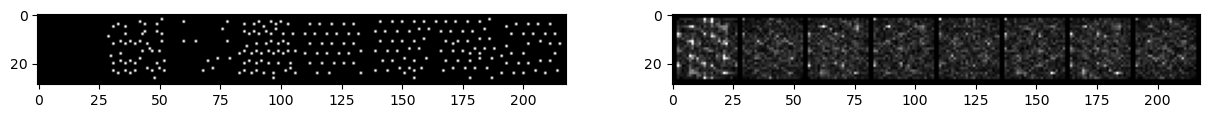

In [90]:
import torch
import numpy as np
from dataset import PointGridDataset
from utils.library import decodewater, view
from torchvision.utils import make_grid
from ase import visualize, Atoms
import tqdm
from matplotlib import pyplot as plt
dts = PointGridDataset("../data/ice_16A_R_hup_low_T_train.hdf5", grid_size=[25, 25, 8], random_transform=True, random_z_compress_for_first_layer=[0.7, 1.0])

# for i in tqdm.tqdm(range(len(dts))):
i = 0
name, fea = dts[i]
fft = torch.fft.fftn(fea[...,(0,)], dim = (0, 1, 2), norm = "ortho")
fft[0,0,0] = 0
fea = fea.permute(2, 3,0,1)[:, (0,)]
fft_img = fft.permute(2, 3,0,1).abs() # Z C H W
#print(fft.abs().mean()) # 0 ~ 3.6, mean ~ 0.17
freq_points = fft[...,0].abs() > 0.75
print(freq_points.sum())
freq_points = freq_points.nonzero()
# print(freq_points)
print(freq_points[:, 0] ** 2 + freq_points[:, 1] ** 2)
U, S, V = np.linalg.svd(freq_points[:, :2].numpy(), full_matrices=False)
print(V)
fea = make_grid(fea)
fft_img = make_grid(fft_img)
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(121)
ax.imshow(fea.permute(1,2,0).detach().numpy())
ax = fig.add_subplot(122)
ax.imshow(fft_img.permute(1,2,0).detach().numpy())
plt.show()



In [155]:
import random
random.getrandbits(1)

1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


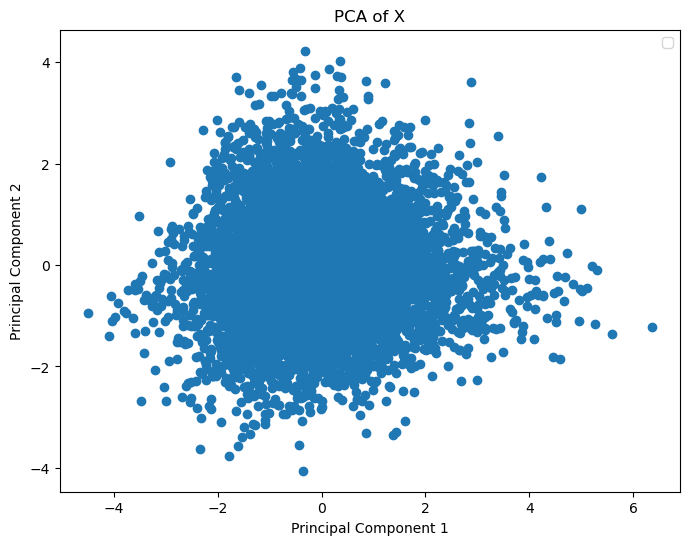

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# 假设 X 是你的数据矩阵，y 是对应的标签（可选）
X = np.load('outputs/2024-03-04/14-41-08/mu.npy')[...,0, 0, 0]
# 标准化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA降维
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 可视化
plt.figure(figsize=(8, 6))

# 如果有标签，可以根据标签绘制不同颜色或样式的点
# # 这里以 y 中的类别作为例子
# for i, label in enumerate(np.unique(y)):
#     plt.scatter(X_pca[y == label, 0], X_pca[y == label, 1], label=f'Class {label}')

# 如果没有标签，直接绘制所有点
plt.scatter(X_pca[:, 0], X_pca[:, 1])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of X')
plt.legend()
plt.show()


In [2]:
import torch
import torch.nn.functional as F

# 假設你的輸入維度
batch_size = 1  # 批次大小
C = 8  # 樣本的通道數
C_prime = 16  # 向量的維度
X, Y = 10, 10  # 樣本的空間維度
seq_len = 1  # 序列長度

# 創建樣本和向量
sample = torch.randn(batch_size, C, X, Y)  # 樣本維度 [batch_size, C, X, Y]
vector = torch.randn(batch_size, C_prime, seq_len)  # 向量維度 [batch_size, C', seq_len]

# 將樣本和向量轉換為適合多頭注意力的格式
sample_flat = sample.view(batch_size, C, -1).permute(2, 0, 1)  # 維度變為 [X*Y, batch_size, C]
vector_flat = vector.permute(2, 0, 1)  # 維度變為 [seq_len, batch_size, C']

# 定義多頭注意力的參數
num_heads = 4  # 多頭注意力的頭數
dropout = 0.1  # Dropout比率

# 使用multi_head_attention_forward執行交叉注意力
# 注意：在這個函數中，key和value通常是相同的
attn_output, attn_output_weights = F.multi_head_attention_forward(
    query=vector_flat,  # 查詢
    key=sample_flat,  # 鍵
    value=sample_flat,  # 值
    embed_dim_to_check=C_prime,
    num_heads=num_heads,
    need_weights=True,
    out_proj_weight=None,
    out_proj_bias=torch.zeros(C_prime),
    training=True
)

TypeError: multi_head_attention_forward() missing 6 required positional arguments: 'in_proj_weight', 'in_proj_bias', 'bias_k', 'bias_v', 'add_zero_attn', and 'dropout_p'

In [18]:
import numpy as np
import torch
def box2vec_np(box_cls: np.ndarray, box_off: np.ndarray, *args, threshold: float = 0.5) -> tuple[np.ndarray, ...]:
    mask = np.nonzero(box_cls > threshold)
    print(mask)
    box_cls = box_cls[mask]
    box_off = box_off[mask] + np.stack(mask, axis = -1)
    args = [arg[mask] for arg in args]
    return box_cls, box_off, *args

def box2vec_th(box_cls: torch.Tensor, box_off: torch.Tensor, *args, threshold: float = 0.5) -> tuple[torch.Tensor, ...]:
    mask = torch.nonzero(box_cls > threshold, as_tuple=True)
    box_cls = box_cls[mask]
    box_off = box_off[mask] + torch.stack(mask, dim = -1)
    box_off = torch.div(box_off, box_cls.new_tensor([1.,1.,1.]))
    args = [arg[mask] for arg in args]
    
    return box_cls, box_off, *args

cls = np.random.rand(10, 10, 1)
off = np.random.rand(10, 10, 1, 3)
box2vec_np(cls, off)

cls = torch.rand(10, 10, 1)
off = torch.rand(10, 10, 1, 3)
box2vec_th(cls, off)

(array([0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 9, 9, 9,
       9]), array([2, 3, 7, 9, 3, 7, 8, 0, 2, 8, 9, 0, 2, 3, 5, 8, 9, 0, 1, 3, 4, 6,
       8, 9, 2, 5, 6, 7, 8, 0, 1, 2, 5, 9, 0, 1, 4, 6, 7, 4, 6, 2, 3, 5,
       6]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0]))


(tensor([0.9953, 0.5371, 0.6364, 0.6320, 0.6013, 0.8490, 0.9929, 0.9345, 0.5937,
         0.8411, 0.7518, 0.6526, 0.7239, 0.8150, 0.9378, 0.5773, 0.5386, 0.7409,
         0.5126, 0.9277, 0.8426, 0.6840, 0.6020, 0.9372, 0.5422, 0.7550, 0.7320,
         0.9311, 0.9448, 0.5869, 0.7138, 0.7082, 0.6373, 0.8334, 0.8855, 0.6349,
         0.5192, 0.8864, 0.6053, 0.8467, 0.5181, 0.8624, 0.6569, 0.7009, 0.5883,
         0.9862, 0.5452, 0.5059, 0.5652, 0.8419, 0.5706, 0.6843, 0.5309, 0.8710]),
 tensor([[0.8380, 0.1550, 0.5295],
         [0.3728, 3.2207, 0.3123],
         [0.3790, 6.3268, 0.0387],
         [0.5965, 7.7964, 0.6467],
         [1.0343, 0.6863, 0.8674],
         [1.0470, 3.4056, 0.2495],
         [1.8931, 4.7710, 0.2726],
         [1.1091, 5.5710, 0.4044],
         [1.9417, 7.9456, 0.7957],
         [1.6280, 8.7417, 0.1568],
         [2.9090, 0.1255, 0.0100],
         [2.6489, 6.4053, 0.8277],
         [2.1820, 8.5900, 0.4092],
         [3.2855, 0.1219, 0.7678],
         [3.7473, 2.57

In [20]:
from utils.library import box2vec
import torch
a = torch.rand(10, 10, 1)
b = torch.rand(10, 10, 1, 3)
box2vec(a, b)

(tensor([0.8577, 0.7149, 0.8304, 0.7499, 0.6161, 0.8658, 0.7839, 0.5136, 0.8946,
         0.9418, 0.7444, 0.9438, 0.7657, 0.8991, 0.7940, 0.9654, 0.5405, 0.6927,
         0.6318, 0.5253, 0.7740, 0.6706, 0.5010, 0.8324, 0.7543, 0.5587, 0.5813,
         0.9843, 0.7673, 0.8900, 0.8681, 0.7904, 0.9734, 0.9862, 0.9257, 0.8838,
         0.5331, 0.7935, 0.5636, 0.5670, 0.6990, 0.7591, 0.7431, 0.6867, 0.5879,
         0.7550, 0.6650, 0.7056]),
 tensor([[0.0581, 0.3625, 0.9933],
         [0.0516, 0.5579, 0.5263],
         [0.0531, 0.8657, 0.4253],
         [0.1281, 0.1080, 0.5154],
         [0.1136, 0.5504, 0.1696],
         [0.1273, 0.7196, 0.5267],
         [0.1215, 0.9944, 0.3480],
         [0.2446, 0.2261, 0.4485],
         [0.2839, 0.3693, 0.3695],
         [0.2489, 0.9079, 0.5936],
         [0.3162, 0.0419, 0.1131],
         [0.3655, 0.1188, 0.6806],
         [0.3259, 0.3969, 0.5259],
         [0.3258, 0.4728, 0.2347],
         [0.3666, 0.6879, 0.3491],
         [0.3453, 0.8589, 0.8916],
